Здравствуйте, Анатолий Игоревич. <br/>
На даный момент я с аспирантом кафедры электроснабжения Димой Яценко провожу небольшое исследование по прогнозированию электрического нагрузки Украины. Модель находится в состоянии разработки, мы с ним разделили обязанности, Дима отвечает за анализ литературных источников и предложение различных математических моделей, а я отвечаю за их реализацию в Пайтоне. <br/>
В этом документе я выложил кусочек своей модели, в котором провел анализ энергопотребления и баланса электрической нагрузки Украины начиная с 1 января 2014 года. <br/>
Целью даного документа является демонстрация моих навыков в области программирования и статистической обработки данных.  <br/>
Спасибо  <br/>

# Content
 * [1. Introduction](#1) <br/>
 * [2. Data Preprocessering](#2) <br/>
 * [3. Exploratory data analysis](#3) <br/>
 * [4. Consumption analysis](#4) <br/>
 * [5. Time Series Forecasting with ARIMA](#5) <br/>
 * [6. Summary](#6) <br/>

In [178]:
# Загружам библиотеки, необходимые для работы
import requests # Загружам библиотеки, необходимые для работы
import json # Позволяет работать с форматом JSON
import pandas as pd # Позволяет структурировать данные в виде таблиц
from matplotlib import pyplot as plt # Позволяет выводить графики прямо в документе
import seaborn as sns # Позволяет делать статистическую визализацию данных
from scipy.stats import norm  # Генерирует параметры нормального распределения
from scipy import stats # Загружает статистические тесты на ошибку первого и второго рода
import statsmodels.api as sm # Загружает платформу для оформления результатов статистического анализа

In [79]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id='1'></a>
# 1. Introduction

В данном документе я хочу провести небольшой анализ графика электрической нагрузки Украины с использованием языка программирования Python и инструментов EDA, или статистического анализа данных

<a id='2'></a>
# 2. Data Preprocessering

Для того, чтобы провести анализ, возьмем данные с сайта <a href="https://ua.energy/diyalnist/dyspetcherska-informatsiya/dobovyj-grafik-vyrobnytstva-spozhyvannya-e-e/">Укрэнерго</a>.<br/>
А именно: графики почасового баланса нагрузки, разработанные ДП «Енергоринок» и утвержденные главным диспетчером Укрэнерго. 
<img src="sdssf.JPG"> 

Нужные нам данные хранятся в базе данных Укрэнерго и выгружаются на сайт в виде уже сформированной таблички через запрос JQuery и фоновый обмен с помощью  <a href="https://ua.energy/diyalnist/dyspetcherska-informatsiya/dohttps://ru.wikipedia.org/wiki/AJAX">AJAX</a> <br/>
Напишем небольшую функцию-парсер для того, чтобы выгрузить необходимые данные в удобном для анализа виде.

In [2]:
def Energy_Parcer(date):
    url = 'https://ua.energy/wp-admin/admin-ajax.php' # название сервера который присылает данные на сайт 
    payload = { # параметры ответа
        "Host": "ua.energy",
        "Connection": "keep-alive",
        "Content-Length": '75',
        "Origin": "https://ua.energy",
        "X-Requested-With": "XMLHttpRequest",
        "User-Agent": "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36",
        "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
        "Accept": "*/*",
        "Referer": "https://ua.energy/diyalnist/dyspetcherska-informatsiya/dobovyj-grafik-vyrobnytstva-spozhyvannya-e-e/",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",
        "Cookie": "_ga=GA1.2.1756074011.1542635370; _gid=GA1.2.785433389.1542635370; _fbp=fb.1.1542635370134.1141896228; pll_language=uk"
    }

    headers = {}
    over = {'action':'get_data_oes', 'report_date': date, 'type':'day', 'rnd': '0.12455644145311262'} # параметры запроса
    return requests.post(url, data=over, json=payload).json()  # функция возвращает выгруженные данные в формате json

Проверим нормально ли работает. Попробуем загрузить баланс электрической нагрузки к примеру в период "27.11.2018"

In [9]:
date = '27.11.2018'
data = pd.DataFrame(Energy_Parcer(date))
data.columns = ['АЕС', 'Споживання','ГАЕС закачка','ГЕС та ГАЕС','Години','ТЕЦ','ТЕС','ВДЕ',]
data = data.set_index(['Години'])

In [10]:
data

,АЕС,Споживання,ГАЕС закачка,ГЕС та ГАЕС,ТЕЦ,ТЕС,ВДЕ
Години,,,,,,,
00:00,10964,18623,-545,136,1087,7843,183
01:00,10996,17902,-942,505,1041,6912,162
02:00,10968,17381,-940,477,1039,6778,116
03:00,10992,17041,-1378,292,1037,7000,85
04:00,10962,17065,-1363,88,1049,7098,99
05:00,10985,17364,-922,88,1042,6717,108
06:00,10960,17995,0,84,1041,6768,103
07:00,10956,19389,0,765,1039,7391,82
08:00,10971,20176,0,840,1039,8218,90


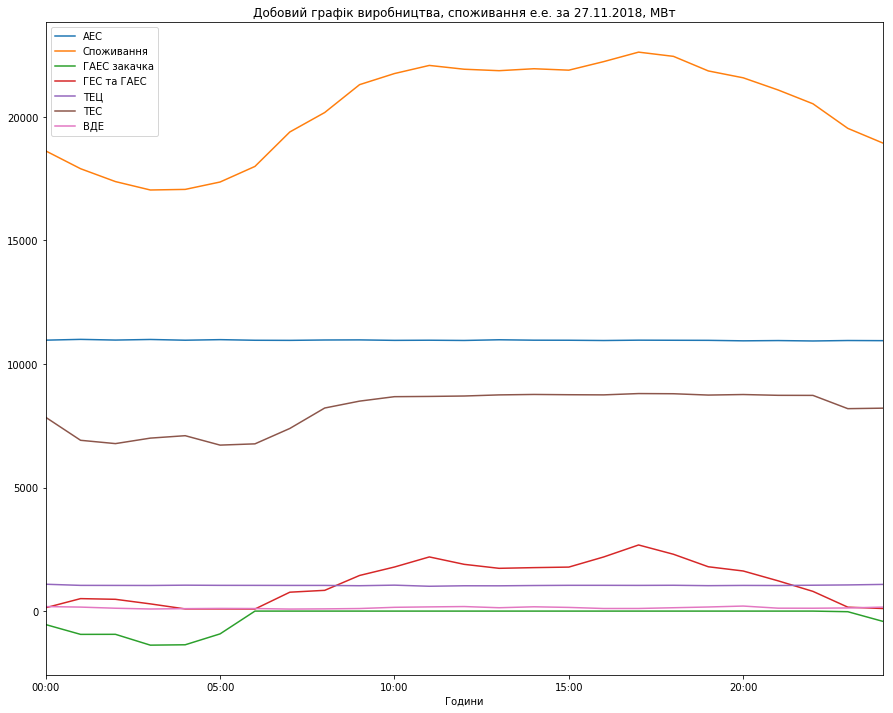

In [106]:
data.plot(figsize = (15,12), title = 'Добовий графік виробництва, споживання е.е. за %s, МВт' %date)
plt.show()

Теперь, когда мы убедились, что функция работает, можем загрузить данные за весь вышеуказанный период.

In [13]:
timerange = list(pd.date_range(start='01/01/2014', end='27/11/2018')) # Период за который нужно выгрузить данные
for i in range(len(timerange)): # Цикл: для кадого дня в указанном периоде
    edata.append(Energy_Parcer(timerange[i].strftime('%d.%m.%Y')))  # в список edata добавляется массив данных за определенный день
    date.append(timerange[i].strftime('%d.%m.%Y')) # в список datе добавляется маркер самой даты, для того, чтобы иметь индексацию
    # и не запутаться
edata = [pd.DataFrame(edata[i]) for i in range(len(edata))] # данные за каждый день структурируются в табличную форму
for i in range(len(edata)):
    edata[i]['Дата'] = date[i] # сортируются по дате
pd.concat(edata).to_csv("Споживання електроенергії.csv") # и выгружаются в текстовый файл "Споживання електроенергії.csv"
# удобство библиотеки pandas в том, что она позволяет сохранить таблицу практически в любой удобный формат - текст, эксель, html и т.д.
# в данном случае удобнее работать с текстовым форматом, так как он занимает меньше места и может быть открыт любым редактором

In [193]:
energy_data = pd.read_csv('Споживання електроенергії.csv', engine = 'python', index_col = 0)  # открываем сохраненные данные

In [194]:
energy_data.columns = ['АЕС', 'Споживання','ГАЕС закачка','ГЕС та ГАЕС','Години','ТЕЦ','ТЕС','ВДЕ', 'Дата']
energy_data.head() 

,АЕС,Споживання,ГАЕС закачка,ГЕС та ГАЕС,Години,ТЕЦ,ТЕС,ВДЕ,Дата
0,10728,20586,0,1809,01:00,2016,8892,50,01.01.2014
1,10606,19665,0,863,02:00,2014,8885,49,01.01.2014
2,10515,19107,0,355,03:00,2022,8731,54,01.01.2014
3,10475,18453,0,185,04:00,2014,8369,42,01.01.2014
4,10427,18072,-488,274,05:00,2009,8355,49,01.01.2014


In [85]:
energy_data['Дата'] = pd.to_datetime(energy_data['Дата'],dayfirst = True)  # Преобразуем столбец "Дата" в формат "дата-время"
energy_data.info () # Проверяем на пустые значения массив

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44766 entries, 0 to 24
Data columns (total 9 columns):
АЕС             44766 non-null int64
Споживання      44766 non-null int64
ГАЕС закачка    44766 non-null int64
ГЕС та ГАЕС     44766 non-null int64
Години          44766 non-null object
ТЕЦ             44766 non-null int64
ТЕС             44766 non-null int64
ВДЕ             44766 non-null int64
Дата            44766 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 3.4+ MB


Попробуем оценить распределение генерации электроэнергии погодово среди разных источников не считая перетоки между странами.


In [111]:
en_y = energy_data.groupby(energy_data['Дата'].dt.year).sum() # Данные суммируются для каждого года
en_y['ГЕС'] = en_y['ГЕС та ГАЕС'] - en_y['ГАЕС закачка'] # Разница между генерацией ГЕС и работой на подкачку
cols = ['АЕС', 'ТЕЦ', 'ТЕС', 'ВДЕ', 'ГЕС'] #  Столбцы генерации электроэнергии
print('\nРозподіл генерації електроенергії від різних джерел, МВт:')
en_y[cols]


Розподіл генерації електроенергії від різних джерел, МВт:


,АЕС,ТЕЦ,ТЕС,ВДЕ,ГЕС
Дата,,,,,
2014,91831455,10479967,86479689,1680456,10154415
2015,91023283,8338507,58235926,1293183,8837385
2016,84130122,7931966,57334147,1126156,11211506
2017,88706840,7625644,51776491,1210903,12547905
2018,78404195,6491411,47928026,1722438,13129521



Розподіл генерації електроенергії за 2014 рік, МВт:


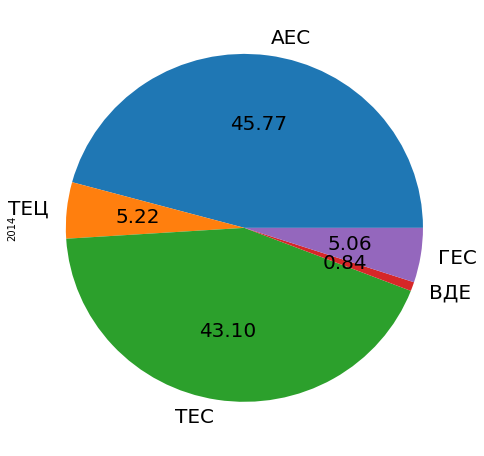


Розподіл генерації електроенергії за 2015 рік, МВт:


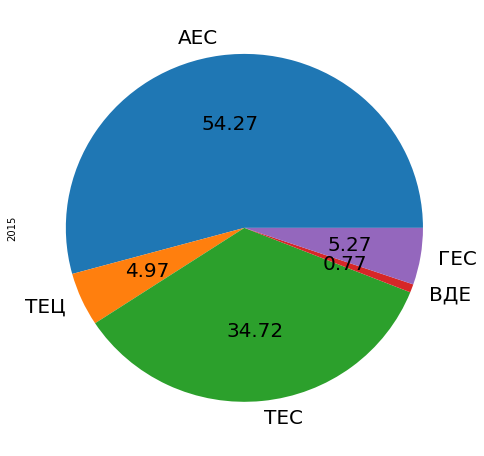


Розподіл генерації електроенергії за 2016 рік, МВт:


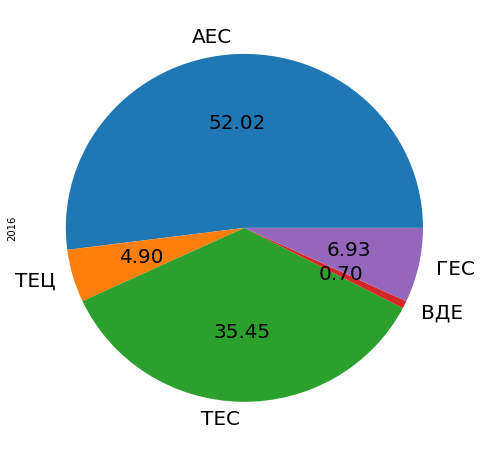


Розподіл генерації електроенергії за 2017 рік, МВт:


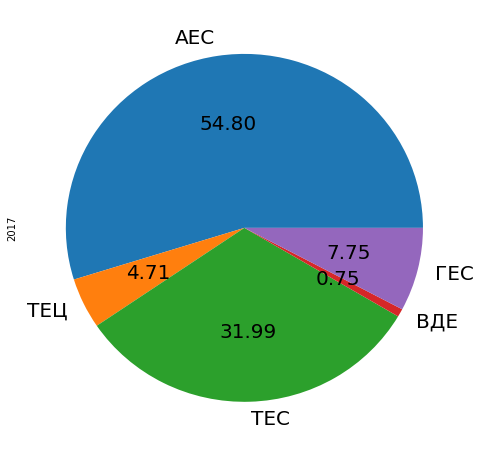


Розподіл генерації електроенергії за 2018 рік, МВт:


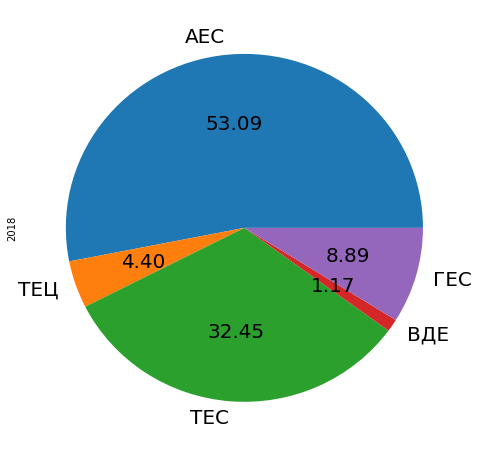

In [114]:
 #  Круговые диаграммы с распределением по каждому году
for i in en_y[cols].index:
    print('\nРозподіл генерації електроенергії за %s рік, МВт:' %i)
    en_y[cols].loc[i].plot.pie(autopct='%.2f', fontsize=20, figsize=(8, 8))
    plt.show()

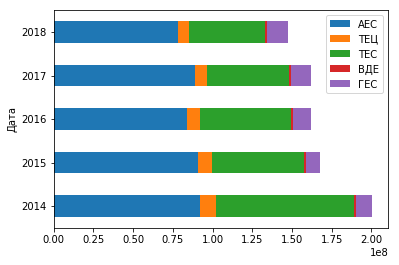

In [123]:
# Сравнительное распределение по типам генерации
en_y[cols].plot.barh(stacked=True);
plt.show()

Как мы можем заметить, к 2018 году постепенно уменьшается использование теплоэлектростанций и теплоэлектроцентралей и идет тенденция увеличения доли ВДЕ и ГЭС в выработке электроэнергии. Отчасти такое распределение можно еще обьяснить тем, что часть достаточно значильная часть ТЭС Украины находится на околоокупированной территории и за счет этого, начиная с 2015 года, она потеряла свою рабочу мощность. <br/>
Проведем более глубокий анализ в следующем разделе

<a id='3'></a>
# 3. Exploratory data analysis 

Построим таблицу описательной статистики баланса электрической нагрузки Украины. В данной таблице обощена центральная тенценция,
распределение и форма распределения входящего набора данных и выведена в виде таких показателей:
 * count - размер выборки
 * mean - размер выборки
 * std - стандартное отклонение для данной выборки
 * min - минимальное значение в выборке
 * 25% - значения до первого квантиля распределения
 * 50% - значения между первым квартилем и серединой
 * 75% - значения до третьего квантиля распределения 
 * max	 - максимальное значение в выборке

In [44]:
print('\nТаблица описательной статистики баланса электрической нагрузки Украины за 2014-2018 год')
energy_data.describe()


Таблица описательной статистики баланса электрической нагрузки Украины за 2014-2018 год


,АЕС,Споживання,ГАЕС закачка,ГЕС та ГАЕС,ТЕЦ,ТЕС,ВДЕ
count,44766.000000,44766.000000,44766.000000,44766.000000,44766.000000,44766.000000,44766.000000
mean,9696.999844,17253.041996,-225.101126,1023.184001,912.913707,6740.702296,157.108877
std,1244.116830,2990.260627,399.664176,797.072319,452.290252,2115.865294,117.900858
min,0.000000,0.000000,-1400.000000,0.000000,0.000000,0.000000,-1.000000
25%,8671.000000,15157.000000,-396.000000,352.000000,557.000000,5228.000000,62.000000
50%,9849.000000,16779.000000,0.000000,850.000000,680.000000,6396.000000,139.000000
75%,10729.000000,19272.000000,0.000000,1540.750000,1205.000000,7836.750000,225.000000
max,12724.000000,30727.000000,0.000000,4515.000000,2622.000000,17967.000000,967.000000


Мы можем обратить внимание на определеннную странность - это нулевое минимальное значение, что вероятно не свойственно как для генерации, так и для потребления электроэнергии. Попробуем выявить причины этого. <br/>
Разобьем распределение баланса мощностей на годовые участки, чтобы сравнить описательную статистику.

In [52]:
print('Таблица описательной статистики баланса электрической нагрузки Украины\n для каждого года за перод 2014-2018 год')
energy_data.groupby(energy_data['Дата'].dt.year).describe().T

Таблица описательной статистики баланса электрической нагрузки Украины
 для каждого года за перод 2014-2018 год


Дата                        2014          2015          2016          2017  \
АЕС          count   9120.000000   9125.000000   9150.000000   9117.000000   
             mean   10069.238487   9975.154301   9194.548852   9729.827794   
             std     1194.838170   1026.118138   1454.697075   1148.590623   
             min     7799.000000   7575.000000   6572.000000      0.000000   
             25%     8700.000000   9246.000000   7798.000000   8723.000000   
             50%    10319.500000   9855.000000   9058.000000   9926.000000   
             75%    11106.500000  10814.000000  10631.000000  10689.000000   
             max    11904.000000  11788.000000  12064.000000  12724.000000   
Споживання   count   9120.000000   9125.000000   9150.000000   9117.000000   
             mean   19648.690351  16884.745425  16478.187213  16551.919820   
             std     3142.267740   2749.242308   2558.944224   2559.394430   
             min    13012.000000  11391.000000  11203.000000      0.000000   
             25%    17521.750000  14950.000000  14752.500000  14792.000000   
             50%    19282.000000  16455.000000  16145.000000  16210.000000   
             75%    21808.750000  18886.000000  18324.000000  18161.000000   
             max    30727.000000  25930.000000  23898.000000  23273.000000   
ГАЕС закачка count   9120.000000   9125.000000   9150.000000   9117.000000   
             mean    -128.880482   -246.665205   -254.809727   -251.782714   
             std      261.332353    411.628955    431.511490    427.592150   
             min    -1186.000000  -1398.000000  -1385.000000  -1388.000000   
             25%      -92.000000   -441.000000   -489.000000   -490.000000   
             50%        0.000000      0.000000      0.000000      0.000000   
             75%        0.000000      0.000000      0.000000      0.000000   
             max        0.000000      0.000000      0.000000      0.000000   
ГЕС та ГАЕС  count   9120.000000   9125.000000   9150.000000   9117.000000   
             mean     984.542215    721.815342    970.491475   1124.536799   
             std      791.606603    638.907542    744.993772    809.980062   
             min       52.000000     40.000000     47.000000      0.000000   
             25%      332.000000    210.000000    326.000000    429.000000   
             50%      807.000000    546.000000    822.500000    975.000000   
             75%     1461.000000   1077.000000   1480.000000   1693.000000   
             max     4202.000000   3519.000000   3983.000000   4019.000000   
ТЕЦ          count   9120.000000   9125.000000   9150.000000   9117.000000   
             mean    1149.119189    913.808986    866.881530    836.420314   
             std      689.195567    444.912510    317.290845    264.475824   
             min      349.000000    358.000000    424.000000      0.000000   
             25%      487.000000    524.000000    581.000000    614.000000   
             50%      915.000000    732.000000    682.500000    667.000000   
             75%     1765.250000   1209.000000   1181.000000   1143.000000   
             max     2622.000000   2423.000000   1481.000000   1317.000000   
ТЕС          count   9120.000000   9125.000000   9150.000000   9117.000000   
             mean    9482.422039   6382.019288   6266.026995   5679.114950   
             std     2136.850734   1471.826016   1235.137565   1530.709973   
             min     4100.000000   3328.000000   3277.000000      0.000000   
             25%     8119.000000   5277.000000   5302.250000   4449.000000   
             50%     9471.500000   6298.000000   6166.000000   5668.000000   
             75%    10736.250000   7375.000000   7119.750000   6815.000000   
             max    17967.000000  12171.000000  10502.000000  10082.000000   
ВДЕ          count   9120.000000   9125.000000   9150.000000   9117.000000   
             mean     184.260526    141.718685    123.077158    132.818142   
             std      

Как можно заметить, нулевое минимальное значение свойственно только для выборки 2017 года, попробуем копнуть немного глубже в данные. 

In [53]:
print('\n Диапазон значений с нулевыми значениями:')
energy_data[energy_data['Споживання'] == 0]


 Диапазон значений с нулевыми значениями:


,АЕС,Споживання,ГАЕС закачка,ГЕС та ГАЕС,Години,ТЕЦ,ТЕС,ВДЕ,Дата
11,0,0,0,0,11:00,0,0,0,2017-06-27
12,0,0,0,0,12:00,0,0,0,2017-06-27
13,0,0,0,0,13:00,0,0,0,2017-06-27
14,0,0,0,0,14:00,0,0,0,2017-06-27
15,0,0,0,0,15:00,0,0,0,2017-06-27
16,0,0,0,0,16:00,0,0,0,2017-06-27
17,0,0,0,0,17:00,0,0,0,2017-06-27
18,0,0,0,0,18:00,0,0,0,2017-06-27
19,0,0,0,0,19:00,0,0,0,2017-06-27
20,0,0,0,0,20:00,0,0,0,2017-06-28


Как мы можем заметить, 27 июня 2017 года в период с 11:00 по 20:00 по какой-то причине на сайте Укрэнерго отсутствуют значения.<br/>
Вероятнее всего это может быть связано с <a href="https://ru.wikipedia.org/wiki/%D0%A5%D0%B0%D0%BA%D0%B5%D1%80%D1%81%D0%BA%D0%B8%D0%B5_%D0%B0%D1%82%D0%B0%D0%BA%D0%B8_%D0%BD%D0%B0_%D0%A3%D0%BA%D1%80%D0%B0%D0%B8%D0%BD%D1%83_(2017)">хакерской атакой</a> на государственные учереждения Украины как раз во вторник 27 июня 2017 года и по этой причине данные просто не загрузились на сервер.
Проведем анализ распределения потребления и генерации на выбросы в распределении методом <a href="https://ru.wikipedia.org/wiki/%D0%AF%D1%89%D0%B8%D0%BA_%D1%81_%D1%83%D1%81%D0%B0%D0%BC%D0%B8">Box-Plot</a>. 

<img src="sdfdsfsdf.JPG">

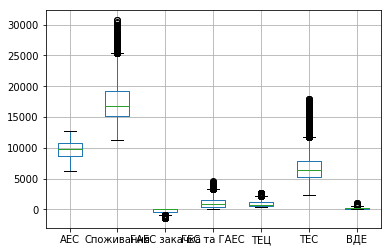

In [57]:
energy_data[energy_data['Споживання'] != 0].boxplot()
plt.show()

Как мы видим,вероятно использовать выборку за все 4 года не совсем корректно для даного метода, так как за это время система прошло достаточно сильное изменение струкутры. Попробуе сравнить "усатые ящики" для каждого года для энергопотребления.

In [102]:
energy_data[energy_data['Дата'] == '2017-06-27']

,АЕС,Споживання,ГАЕС закачка,ГЕС та ГАЕС,Години,ТЕЦ,ТЕС,ВДЕ,Дата
0,9271,14365,-361,102,00:00,545,5412,16,2017-06-27
1,9242,13558,-503,353,01:00,545,4498,9,2017-06-27
2,9272,12920,-951,183,02:00,545,4422,6,2017-06-27
3,9286,12768,-1178,283,03:00,532,4443,6,2017-06-27
4,9305,12776,-1163,356,04:00,539,4357,3,2017-06-27
5,9330,12804,-1158,355,05:00,540,4267,3,2017-06-27
6,9342,13204,-404,140,06:00,541,4064,12,2017-06-27
7,9323,14138,0,144,07:00,543,4609,30,2017-06-27
8,9325,14891,0,555,08:00,538,4813,56,2017-06-27
9,9364,15872,0,1402,09:00,541,5019,91,2017-06-27


In [93]:
energy_data[energy_data['Споживання'] == 0]

,АЕС,Споживання,ГАЕС закачка,ГЕС та ГАЕС,Години,ТЕЦ,ТЕС,ВДЕ,Дата
11,0,0,0,0,11:00,0,0,0,2017-06-27
12,0,0,0,0,12:00,0,0,0,2017-06-27
13,0,0,0,0,13:00,0,0,0,2017-06-27
14,0,0,0,0,14:00,0,0,0,2017-06-27
15,0,0,0,0,15:00,0,0,0,2017-06-27
16,0,0,0,0,16:00,0,0,0,2017-06-27
17,0,0,0,0,17:00,0,0,0,2017-06-27
18,0,0,0,0,18:00,0,0,0,2017-06-27
19,0,0,0,0,19:00,0,0,0,2017-06-27
20,0,0,0,0,20:00,0,0,0,2017-06-28


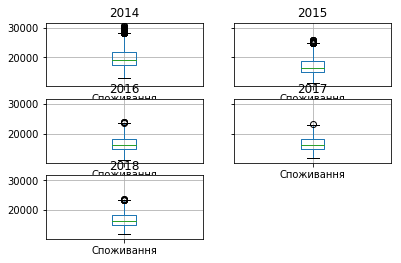

In [82]:
pd.DataFrame(energy_data['Споживання']).groupby(energy_data['Дата'].dt.year).boxplot()
plt.show()


 розподіл навантаження АЕС, МВт


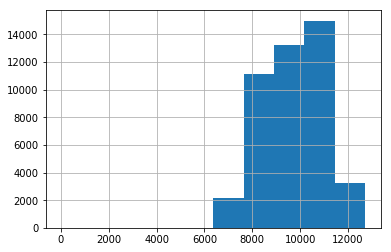


 розподіл навантаження Споживання, МВт


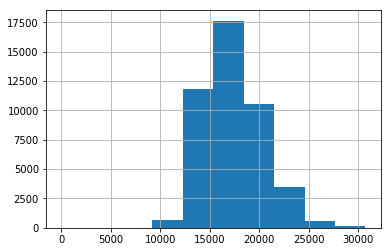


 розподіл навантаження ГАЕС закачка, МВт


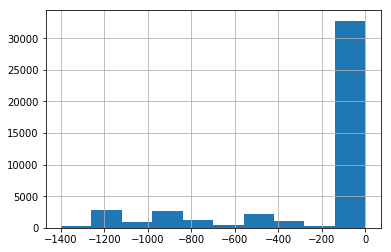


 розподіл навантаження ГЕС та ГАЕС, МВт


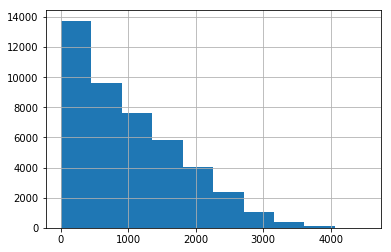


 розподіл навантаження Години, МВт


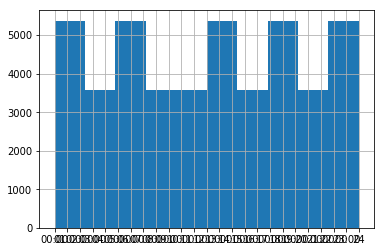


 розподіл навантаження ТЕЦ, МВт


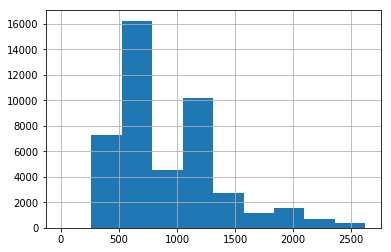


 розподіл навантаження ТЕС, МВт


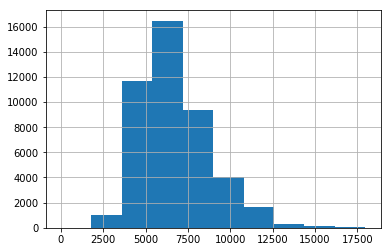


 розподіл навантаження ВДЕ, МВт


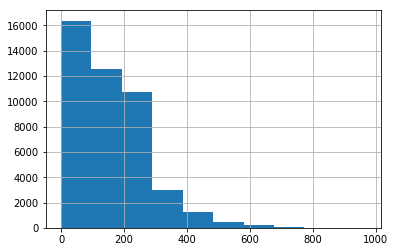

In [73]:
for i in energy_data.columns[energy_data.columns != 'Дата']:
    print('\n розподіл навантаження %s, МВт' %i)
    energy_data[i].hist()
    plt.show()

Как можно заметить, распределение потребления электроэнергии и распределение генерации электроэнергии на ТЭС очень близкое к нормальному распределению. А распределение ГЭС и ВДЕ очень напоминает геометрическое распределение.
В любом случае дальше будем работать с Потреблением электроэнергии, но сначала проверим все таки распределение на нормальность.

mu = 17,256.90 and sigma = 2,979.42


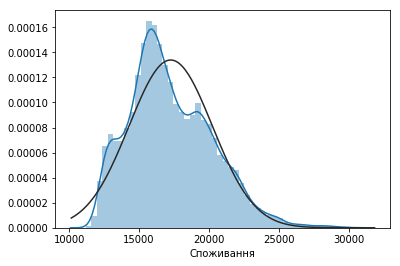

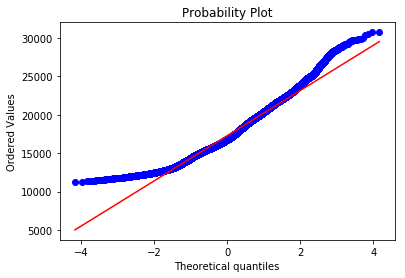

In [125]:
sns.distplot(energy_data[energy_data['Споживання'] != 0]['Споживання'], fit = norm)
(mu, sigma) = norm.fit(energy_data[energy_data['Споживання'] != 0]['Споживання'])
print('mu = {:,.2f} and sigma = {:,.2f}'.format(mu, sigma))
# Q-Q plot:
fig = plt.figure()
res = stats.probplot(energy_data[energy_data['Споживання'] != 0]['Споживання'], plot=plt)
plt.show()

Как мы видим из графика Q-Q Plot данное распределение имеет определенные выбросы в первом и последнем квантиле, которые выходят за границы нормального распределения. <br/>
Как известно, нормальное распределение имеет функцию 
<img src="323432.JPG"> 
где μ - математическое ожидание, которое при нормальном распределении должно быть одновременно модой и медианой, а σ ²  - дисперсия, или квадрат стандартного отклонения, что определяет изменчивость модели, или суму среднеквадратических отклонений от мат. ожидания <br/>
В нашем случае μ = 17,256.90 МВт, а σ = 2,979.42 МВт

В следующем разделе сосредоточимся на анализе только ГЭН энергопотребления Украины. Попробуем выявить новые закономерности, гипотезы и особенности.

<a id='4'></a>
# 4. Consumption analysis 

Оставим только массив с данными энергопотребления за период 2014-2018 год

In [195]:
cols = ['Споживання', 'Години', 'Дата']
energy_data = energy_data[energy_data['Споживання'] != 0][cols]
energy_data = energy_data[energy_data['Години'] != '24']
energy_data['Date'] = energy_data['Дата'] + ' ' +  energy_data['Години']
energy_data['Дата'] = pd.to_datetime(energy_data['Дата'], dayfirst = True)

In [212]:
energy_data.set_index(['Date']).head()

,Споживання,Години,Дата
Date,,,
2014-01-01 01:00:00,20586,01:00,01.01.2014
2014-01-01 02:00:00,19665,02:00,01.01.2014
2014-01-01 03:00:00,19107,03:00,01.01.2014
2014-01-01 04:00:00,18453,04:00,01.01.2014
2014-01-01 05:00:00,18072,05:00,01.01.2014


Построим график энергопотребления сгруппированного по дням для того, чтобы оценить тенденцию, разброс и сезонность данного временного ряда:

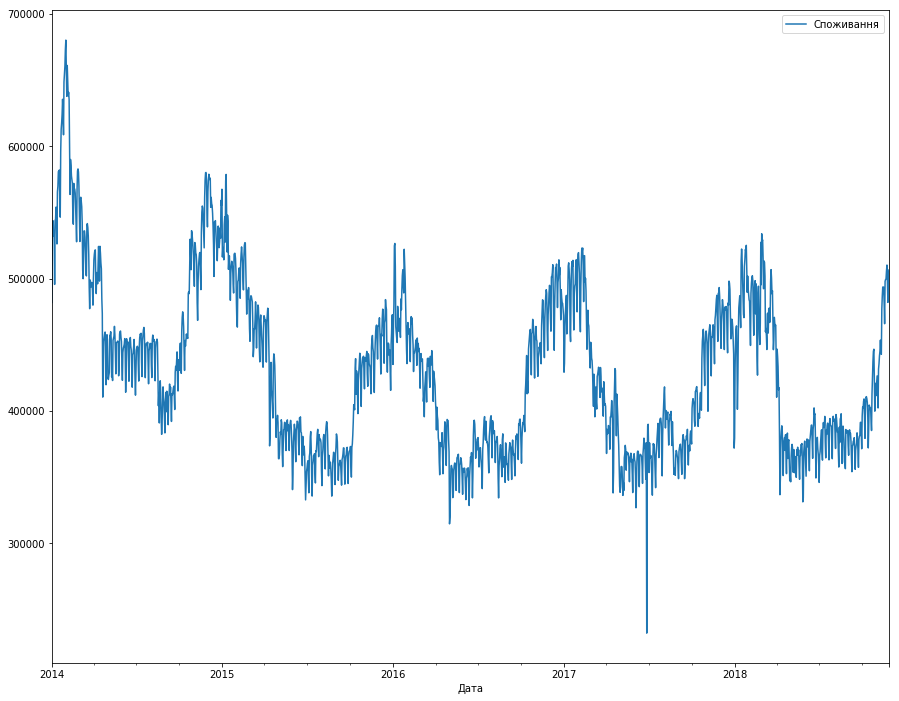

In [176]:
energy_data.groupby(energy_data['Дата']).sum().plot(figsize = (15,12))
plt.show()

Как мы помним, у нас имеется один сильный выброс из общего распределения, который мы видим на графике, связанный с отсутствующими данными, возможно для следующего анализа имеет смысл заполнить эти пропущенные данные хотябы методом  <a href="https://ru.wikipedia.org/wiki/%D0%A1%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B0%D1%8F_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D1%8F%D1%8F_(%D0%B8%D0%BD%D0%B4%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)">скользящей средней</a> <br/>
Как мы можем заметить, мало того, что сам график электрической нагрузки имеет ярко выраженную цикличность по времени, что кстати тоже любопытно было бы оценить. Можно попробовать в следующем разделе найти зависимость изменения общего графика электрической нагрузки от тарифной политики выравнивания, которой менялась на указанном временно промежутке, думаю сегодня этим займусь. А, так вот, даже график энергопотребления, разбитый по дням, как и свойственно собственно временному ряду, имеет ярко выраженную закономерность сезонности, а также общую тенденцию к спаду. Попробуем разложить на временной ряд на три отдельные составляющие: тренд, сезонность и шум. Про эти три явления временных рядов я могу описать в отдельной статье.

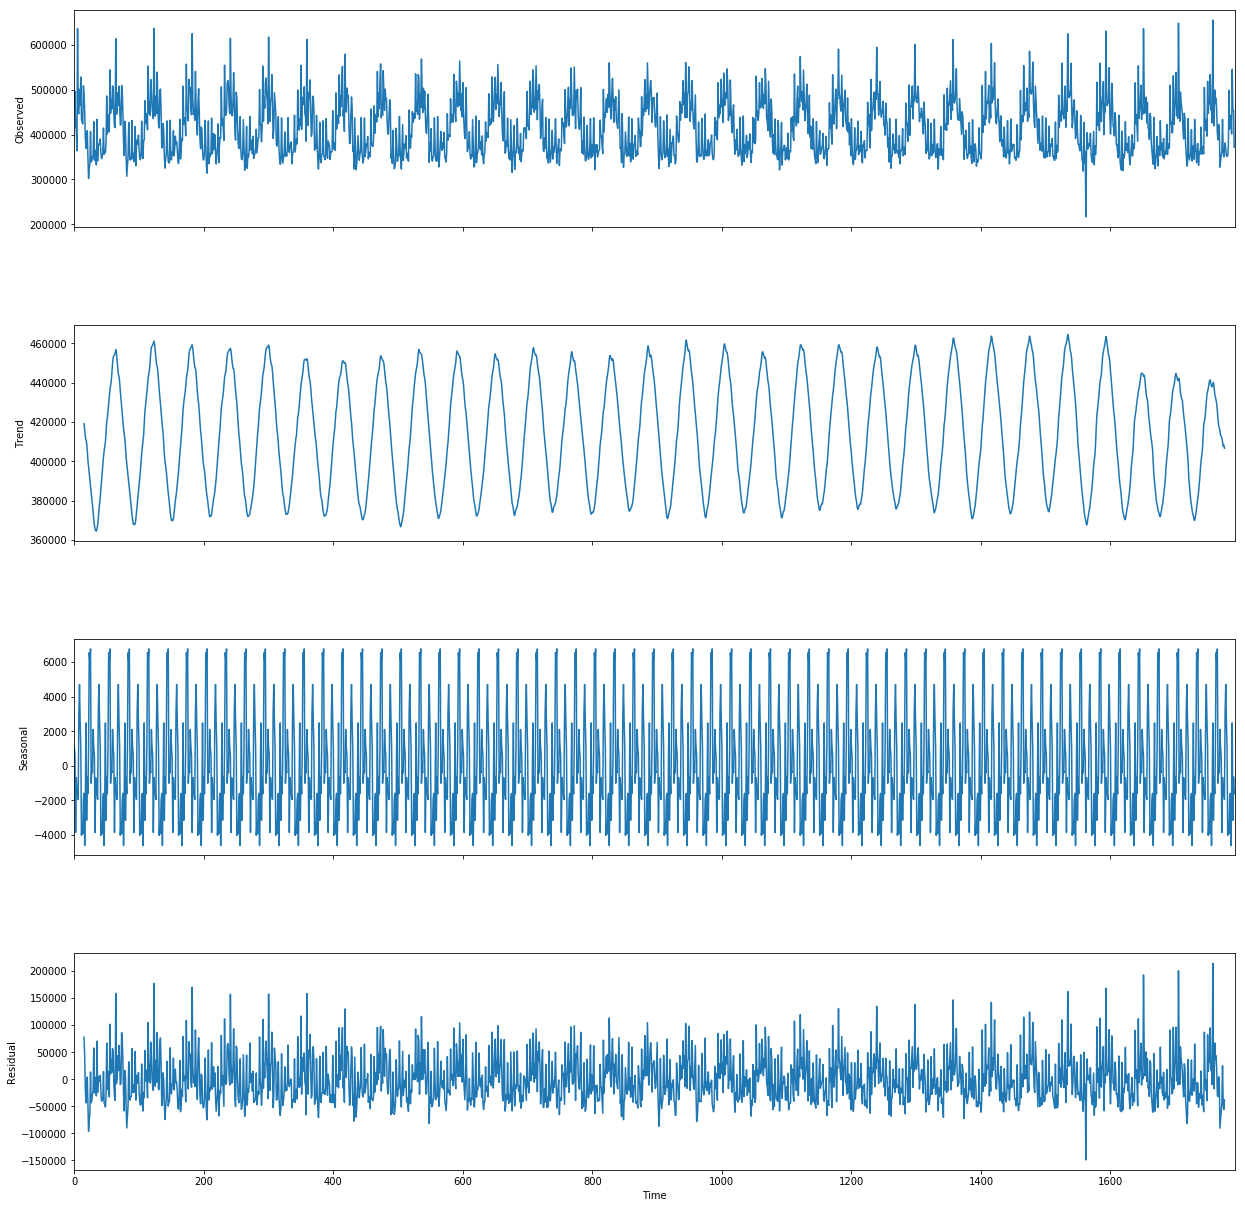

In [210]:
decomposition = sm.tsa.seasonal_decompose(energy_data.groupby(energy_data['Дата']).sum().values, model='additive', freq=30)
fig = decomposition.plot()
fig.set_size_inches(20,20)
plt.show()
